In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive

/content/drive


In [5]:
cd MyDrive

/content/drive/MyDrive


In [6]:
cd WeatherForecastingApp/

/content/drive/MyDrive/WeatherPredictionProvaVecchia


In [7]:
cd notebooks

/content/drive/MyDrive/WeatherPredictionProvaVecchia/notebooks


In [ ]:
!pip install catboost
!pip install feature_engine
!pip install "dask[dataframe]"
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.2
!pip install --upgrade threadpoolctl
!pip list | grep scikit

# Weather Forecasting App - Models Performance Study
In this notebook, we **evaluate the performance** of **various classification model**s to identify the most suitable one for our pipeline. This evaluation is conducted using a structured pipeline approach, and the details of the model comparison are presented in a separate file for clarity. In the final pipeline, only the model that demonstrates the best performance will be included to ensure optimal results while maintaining simplicity and efficiency.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    OrdinalEncoder, 
    LabelEncoder, 
    FunctionTransformer
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    RandomizedSearchCV, 
    StratifiedKFold
)
from sklearn.metrics import (
    roc_auc_score, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    classification_report, 
    f1_score, 
    accuracy_score, 
    mutual_info_score,
    precision_recall_curve, 
    auc
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from feature_engine.selection import DropFeatures
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from joblib import dump, load
from collections import Counter

In [8]:
# load the data
data = pd.read_csv('../data/seattle-weather-cleaned.csv')

In [9]:
# check the target variable distribution
data.weather.value_counts()

,count
weather,
sun,629
rain,417
fog,99
drizzle,53
snow,13


In [10]:
def check_missing_value(data):
    columns = data.columns
    for column in columns:
      missing_values = data[column].isnull().sum()
      if missing_values > 0:
         print(f"There are {missing_values} missing values in the column {column}.")
      else:
         print(f"There are no missing values in the column {column}.")

check_missing_value(data)

There are no missing values in the column date.
There are no missing values in the column precipitation.
There are no missing values in the column temp_max.
There are no missing values in the column temp_min.
There are no missing values in the column wind.
There are no missing values in the column weather.


In [11]:
def impute_median(data, var):
    temp = data[data[var].notnull()]
    temp = temp[[var, 'weather']].groupby(['weather'])[[var]].median()
    for val in data['weather'].unique():
        data.loc[(data['weather'] == val) & (data[var].isnull()), var] = temp.loc[val, var]
    return data
#%%
# impute missing values
data = impute_median(data, 'precipitation')
data = impute_median(data, 'temp_max')
data = impute_median(data, 'temp_min')
data = impute_median(data, 'wind')

In [12]:
# check the first few rows of the data
data.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-03,0.8,11.7,7.2,2.3,rain
2,2012-01-05,1.3,8.9,2.8,6.1,rain
3,2012-01-06,2.5,4.4,2.2,2.2,rain
4,2012-01-07,0.0,7.2,2.8,2.3,rain


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211 entries, 0 to 1210
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1211 non-null   object 
 1   precipitation  1211 non-null   float64
 2   temp_max       1211 non-null   float64
 3   temp_min       1211 non-null   float64
 4   wind           1211 non-null   float64
 5   weather        1211 non-null   object 
dtypes: float64(4), object(2)
memory usage: 56.9+ KB


In [14]:
data.describe()

,precipitation,temp_max,temp_min,wind
count,1211.000000,1211.000000,1211.000000,1211.000000
mean,0.763501,17.248803,8.468126,2.928406
std,1.541859,7.549602,5.182635,1.140807
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,11.100000,4.400000,2.100000
50%,0.000000,17.200000,8.900000,2.800000
75%,0.500000,23.300000,12.800000,3.700000
max,6.900000,35.600000,18.300000,6.100000


In [15]:
# separating Day, Month and Year
data['date'] = pd.to_datetime(data['date'])
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

In [17]:
# split the data into features and target
y = data['weather']
X = data.drop(['weather'], axis=1)

# convert all data to numeric, coercing invalid values to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# check for the presence of NaN or infinite values in the original data
print(f"Any NaN values in X? {np.any(np.isnan(X))}")
print(f"Any infinite values in X? {np.any(np.isinf(X))}")

# encode the target column 'weather' into numeric values
le = LabelEncoder()
y = le.fit_transform(y)  # Encode all labels

# print the mapping of classes
print("Class mapping:")
for class_idx, class_label in enumerate(le.classes_):
    print(f"{class_idx}: {class_label}")

# check for the presence of NaN or infinite values in the target data after encoding
print(f"Any NaN values in y? {np.any(np.isnan(y))}")
print(f"Any infinite values in y? {np.any(np.isinf(y))}")

# split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# use stratification to maintain the class distribution in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Any NaN values in X? False
Any infinite values in X? False
Class mapping:
0: drizzle
1: fog
2: rain
3: snow
4: sun
Any NaN values in y? False
Any infinite values in y? False


## TRAINING OF VARIOUS CLASSIFICATION MODELS
The training process involves the evaluation of **multiple classification models** to determine the **best performing one** for the given dataset. A systematic **pipeline** is utilized to preprocess data, address class imbalances, and fine-tune model parameters using techniques like SMOTE and TomekLinks. Several models, including RandomForest, XGBoost, LightGBM, CatBoost, and Logistic Regression, among others, are trained with their respective hyperparameter grids. The training employs **GridSearchCV to optimize parameters** and evaluate models based on **weighted F1-score**, ensuring robust performance.

In [16]:
# define the columns transformer
transformer = ColumnTransformer([
	# Step 1: apply steps for real features
	('precipitation', make_pipeline(
		SimpleImputer(missing_values=np.nan, strategy='median'),
		#KNNImputer(n_neighbors=5),
		StandardScaler()),
	  make_column_selector(pattern='precipitation')
	 ),
	# Step 2: apply steps for real features
	('temp_max', make_pipeline(
		SimpleImputer(missing_values=np.nan, strategy='mean'),
		#KNNImputer(n_neighbors=5),
		StandardScaler()),
	  make_column_selector(pattern='temp_max')
	 ),
	# Step 2: apply steps for real features
	('temp_min', make_pipeline(
		SimpleImputer(missing_values=np.nan, strategy='mean'),
		#KNNImputer(n_neighbors=5),
		StandardScaler()),
	  make_column_selector(pattern='temp_min')
	 ),
	# Step 2: apply steps for real features
	('wind', make_pipeline(
		SimpleImputer(missing_values=np.nan, strategy='mean'),
		#KNNImputer(n_neighbors=5),
		StandardScaler()),
	  make_column_selector(pattern='wind')
	 ),
	# Step 2: apply steps for categorical features
	('day', make_pipeline(
		SimpleImputer(strategy='most_frequent'),
		OneHotEncoder(categories='auto', drop='first', handle_unknown='ignore')),
	  make_column_selector(dtype_include='category')
	 ),
	('month', make_pipeline(
		SimpleImputer(strategy='most_frequent'),
		OneHotEncoder(categories='auto', drop='first', handle_unknown='ignore')),
	  make_column_selector(dtype_include='category')
	 ),
	('year', make_pipeline(
		SimpleImputer(strategy='most_frequent'),
		OneHotEncoder(categories='auto', drop='first', handle_unknown='ignore')),
	  make_column_selector(dtype_include='category')
	 )
 ],

	remainder='passthrough',
	verbose_feature_names_out=True,
	sparse_threshold=0
)
transformer

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('precipitation',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ebbf3805ba0>),
                                ('temp_max',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standar...
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ebbf3804580>),
                                ('year',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ebbf38064a0>)])

In [ ]:
# define the general pipeline
base_pipeline = IMBPipeline(steps=[
    ('drop_columns', FunctionTransformer(lambda X: X.drop(columns=['month', 'day', 'year'], errors='ignore'))),
    ('transformer', transformer),
    ('smote', SMOTE(random_state=42)),
    ('tomek', TomekLinks()),
    ('classifier', None)  # Classifier placeholder
])

In [ ]:
# list of models and respective parameters
model_list = [
    ("RandomForest", RandomForestClassifier(class_weight='balanced', random_state=42)),
    ("RandomForest", RandomForestClassifier()),
    ("XGBoost", XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ("LightGBM",LGBMClassifier(class_weight='balanced', random_state=42, max_depth=10, min_child_samples=5, min_child_weight=1e-6, num_leaves=31, learning_rate=0.1, verbose=-1 )),
    ("CatBoost", CatBoostClassifier(auto_class_weights='Balanced', silent=True, random_state=42)),
    ("MLP", MLPClassifier(random_state=42, early_stopping=True, max_iter=500)),
    ("DecisionTree", DecisionTreeClassifier(class_weight='balanced', random_state=42)),
    ("LogisticRegression", LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)),
    ("KNeighbors", KNeighborsClassifier())
]

model_params_grid = [
    {   # RandomForest
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [5, 10, 20, None],
        'classifier__max_features': ['sqrt']
    },
    {   # RandomForest without class-weighting
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [5, 10, 20, None],
        'classifier__max_features': ['sqrt']
    },
    {   # XGBoost
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [5, 10],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__scale_pos_weight': [10, 20, 30]  # Experiment with higher weights
    },
    {   # LightGBM
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [5, 10, 20, -1],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__class_weight': ['balanced']
    },
    {   # CatBoost
        'classifier__iterations': [100],
        'classifier__depth': [3, 5],
        'classifier__learning_rate': [0.01, 0.1],
    },
    {   # MLP
        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'classifier__activation': ['relu', 'tanh'],
        'classifier__alpha': [0.0001, 0.001],
        'classifier__learning_rate_init': [0.001, 0.01]
    },
    {   # DecisionTree
        'classifier__max_depth': [5, 10, 20, None],
        'classifier__min_samples_split': [2, 5, 10]
    },
    {   # LogisticRegression
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__solver': ['lbfgs', 'liblinear']
    },
    {   # KNeighborsClassifier
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    }
]

In [ ]:
# execute GridSearchCV for each model
best_models_gs = []
for (model_name, model), hp in zip(model_list, model_params_grid):
    print(f"\nRunning GridSearch for {model_name}...")

    try:
        # Create a specific pipeline for the current model
        pipeline = base_pipeline.set_params(classifier=model)

        # Run GridSearchCV
        grid = GridSearchCV(
            estimator=pipeline,
            param_grid=hp,
            cv=5,
            scoring='f1_weighted',
            n_jobs=2,  # Limit to 2 parallel jobs
            verbose=2
        )


        grid.fit(X_train, y_train)  # Train the model

        # save the best results
        print(f"Model: {model_name}")
        print(f"Best parameters: {grid.best_params_}")
        print(f"Best score (F1-weighted): {grid.best_score_}")
        best_models_gs.append((model_name, grid.best_estimator_, grid.best_score_, grid.best_params_))
    except Exception as e:
        print(f"Error during execution of {model_name}: {e}")

# select the best model
hof_model_gs = max(best_models_gs, key=lambda item: item[2])
print(f"\nBest model: {hof_model_gs[0]}")
print(f"Best parameters: {hof_model_gs[3]}")

# evaluate the best model
best_model = hof_model_gs[1]
y_pred_test = best_model.predict(X_test)
print("\nClassification report on the test set:")
print(classification_report(y_test, y_pred_test))


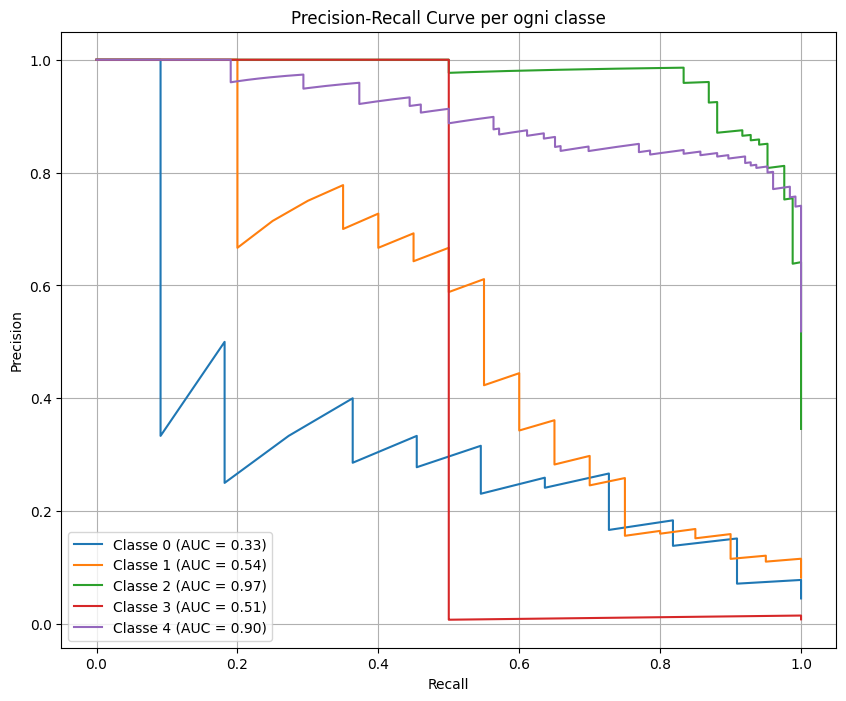

In [59]:
# compute predicted probabilities for each class
y_scores = best_model.predict_proba(X_test)

# transform the labels into a binarized format (one-vs-all)
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# calculate Precision-Recall for each class
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(np.unique(y)):
    precision, recall, thresholds = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'Class {class_label} (AUC = {pr_auc:.2f})')

# display the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.grid()
plt.show()

# TRIAL


In [61]:
# inspect original class distribution
class_counts = Counter(y_train)
print("Original class distribution:", class_counts)

# create a valid sampling strategy
target_samples = max(class_counts.values())  # Target to match the majority class
sampling_strategy = {cls: max(count, target_samples) for cls, count in class_counts.items()}

# apply SMOTE with the valid sampling strategy
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

xgb_pipeline = IMBPipeline(steps=[
    ('drop_columns', FunctionTransformer(lambda X: X.drop(columns=['month', 'day', 'year'], errors='ignore'))),
    ('transformer', transformer),
    ('smote', smote),  # Oversample minority classes
    ('tomek', TomekLinks()),  # Clean noisy majority class samples
    ('classifier', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

# define the parameter grid (removed scale_pos_weight)
xgb_param_grid = {
    'classifier__learning_rate': [0.01, 0.05],
    'classifier__max_depth': [10, 12],
    'classifier__n_estimators': [100, 200],
    'classifier__subsample': [0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8],
}

# stratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# gridSearchCV
xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_param_grid,
    cv=stratified_kfold,
    scoring='f1_weighted',
    n_jobs=2,  # Use parallel jobs
    verbose=2
)

# fit the model
print("Training XGBoost model with pipeline...")
xgb_grid.fit(X_train, y_train)

# best model and evaluation
print("\nBest Parameters for XGBoost:")
print(xgb_grid.best_params_)
print("\nBest F1-Weighted Score:")
print(xgb_grid.best_score_)

# evaluate on the test set
y_pred_test = xgb_grid.best_estimator_.predict(X_test)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_test))


Original class distribution: Counter({4: 503, 2: 333, 1: 79, 0: 42, 3: 11})
Training XGBoost model with pipeline...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best Parameters for XGBoost:
{'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'classifier__subsample': 0.9}

Best F1-Weighted Score:
0.7772190591166876

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.24      0.64      0.35        11
           1       0.35      0.60      0.44        20
           2       0.95      0.88      0.91        84
           3       0.50      0.50      0.50         2
           4       0.88      0.70      0.78       126

    accuracy                           0.75       243
   macro avg       0.58      0.66      0.60       243
weighted avg       0.83      0.75      0.78       243



In [62]:
# inference Code for Custom Input
def predict_weather(xgb_model, custom_input):
    # convert custom input to DataFrame
    input_df = pd.DataFrame([custom_input])

    # ensure column names match training data
    required_columns = ['date', 'precipitation', 'temp_max', 'temp_min', 'wind']
    input_df = input_df[required_columns]  # Match required column order

    # perform prediction
    predicted_class = xgb_model.predict(input_df)[0]
    predicted_probabilities = xgb_model.predict_proba(input_df)[0]

    return predicted_class, predicted_probabilities

# example custom input
custom_input = {
    'precipitation': 0.0,  # No precipitation
    'wind': 2.0,           # Low wind
    'temp_max': 40,      # Moderate temperature
    'temp_min': 35,       # Close to max temperature
    'date': 0              # Placeholder for date
}

# use the best estimator from GridSearchCV (replace xgb_grid.best_estimator_ with your model)
xgb_best_model = xgb_grid.best_estimator_

# predict using the custom input
predicted_class, predicted_probabilities = predict_weather(xgb_best_model, custom_input)

# output the results
weather_conditions = {
    0: "drizzle",
    1: "fog",
    2: "rain",
    3: "snow",
    4: "sun"
}

predicted_weather = weather_conditions.get(predicted_class, "Unknown")
print(f"Predicted Class: {predicted_weather}")
print(f"Predicted Probabilities: {predicted_probabilities}")


Predicted Class: sun
Predicted Probabilities: [0.04166952 0.00911666 0.04366316 0.00660159 0.8989491 ]
